Необходимо разметить оставшуюся часть набора данных на основании имеющейся информации.

In [ ]:
import pandas as pd
import numpy as np
from scipy import sparse
from scipy.sparse import hstack
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split,KFold
from sklearn import linear_model
from catboost import CatBoostRegressor
from nltk import sent_tokenize, word_tokenize, regexp_tokenize
from pymorphy2 import MorphAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
import gc
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_colwidth', -1)
pd.options.mode.use_inf_as_na = True
display(HTML("<style>.container { width:60% !important; }</style>"))
from pylab import rcParams
rcParams['figure.figsize'] = 12,6

In [2]:
df = pd.read_csv('regression_task.csv')
df.sample(10,random_state=1888)

,SubjectId,PL_Description,target
84252,Фургон изотермический 37632А,Заводской номер,NaN
41814,355919101122887,Samsung Galaxy A70 128ГБ Черный,NaN
243832,NaN,Авиадвигатель ТВ3-117ВМ № 7087884200226 вертолета Ми-8 МТВ-1 RA 25134 сер.№95750,457627.12
214466,NaN,Вагон-дом Кедр К-6-2 (столовая) куст №113,56497.46
239770,NaN,Автомобиль легковой KIA UM (Sorento),2355129.17
73404,161068560,ЭЛЕКТРОПОГРУЗЧИК CPD16 JAC,NaN
203827,NaN,Автомобиль медицинской службы 1742C3 с установл. комплектом мед. оборудования,3429649.17
224279,NaN,"Упаковочный автомат ""Бестром-202""",2089500.00
98941,138 571,Sprinter Classic 311 CDI,NaN
65484,Система видеонаблюдения; Система защиты от краж,Система видеонаблюдения в комплекте; Система защиты от краж в комплекте.,NaN


Текст имеет разнородную структуру, поэтому необходимо над ним провести ряд операций:
* Конкатенация столбцов и удаление повторяющейся информации.
* Приведение всех слов текста в нормальную форму.
* Категоризация по прямым и косвенным признакам - присваиваем каждой записи свою категорию на основе наличия ключевых слов в тексте. Это позволит для каждой категории строить отдельную регрессионную модель.

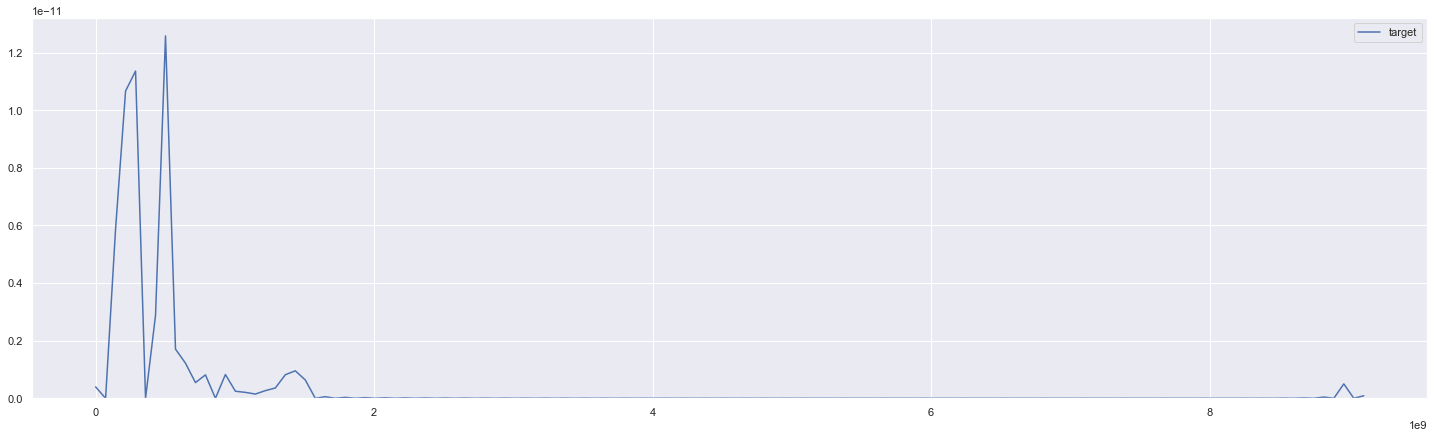

In [75]:
sns.kdeplot(df.target);

Основная сумма стоимости услуг сосредоточена в категориях автотранспорта и спецтехники, несмотря на лизинг танкеров и самолётов.
Возьмём логарифм от стоимости, чтобы получить распределение близкое к нормальному:

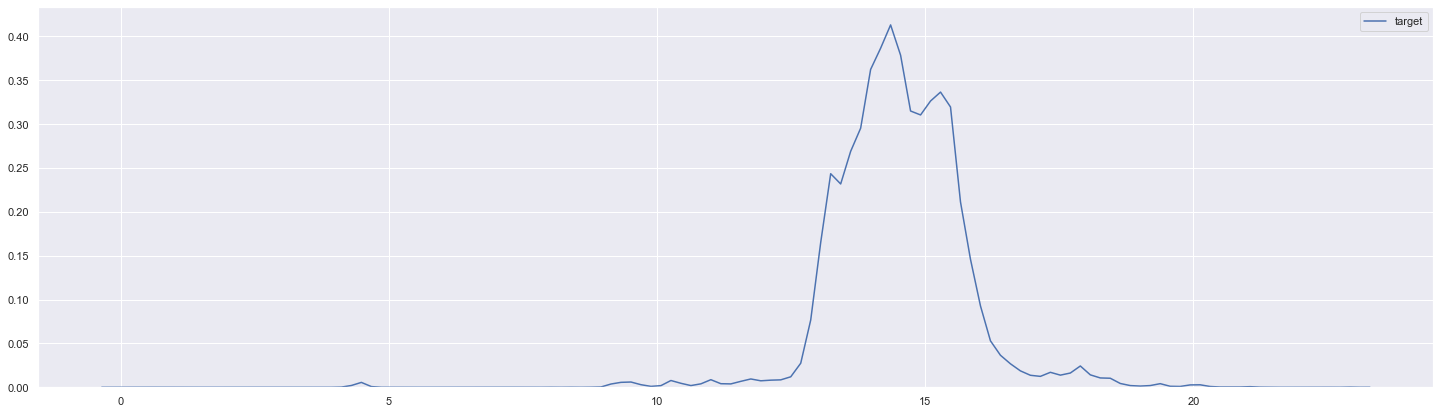

In [76]:
sns.kdeplot(np.log1p(df.target));

Из-за наличия выбросов и сходства с бимодальной формой нельзя рассматривать распределение как нормальное.

### Pre-processing

In [8]:
df = pd.read_csv('regression_task.csv')
df.columns = ['a','d','target']
for col in ['a','d']:
    df.loc[df[col].isna(),col] = '' #заменим NaN'ы пустыми строками
    df.loc[df[col].notna(),col] = df.loc[df[col].notna(),col].apply(lambda x: x.lower()) #преобразуем весь текст в нижний регистр
    df.loc[df[col].isin(['н/д','отсутствует','нет данных']),col] = np.nan
    df[col] = df[col].str.replace(',|-|–|шт./ч|шт/ч|шт.\ч|шт\ч',' ')

In [9]:
df['a'] = df['a'].astype(str) + " " + df['d'].astype(str)
df['a'] = df['a'].str.split().apply(lambda x: ' '.join(list(set(x)))) 
df.drop('d',axis=1,inplace=True)

In [10]:
%%time
# Проведём лемматизацию текста:
def tokenize_n_normalize(sent, pat=r"(?u)\b\w\w+\b", morph=MorphAnalyzer()):
    return [morph.parse(tok)[0].normal_form 
            for tok in regexp_tokenize(sent, pat)]
df['a'] = df['a'].map(lambda x: " ".join(tokenize_n_normalize(x)))

Wall time: 3min 11s


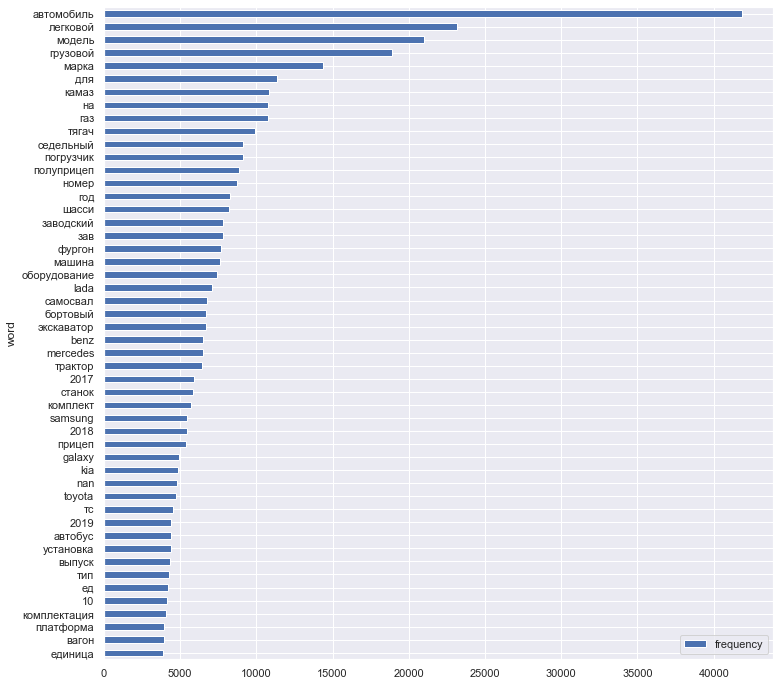

In [11]:
vc = df['a'].str.split(expand=True).stack().value_counts().to_frame().reset_index().head(50)
vc.columns = ['word','frequency']
rcParams['figure.figsize'] = 12,12
ax = vc.sort_values('frequency').plot.barh(x='word', y='frequency')

Как видно, из статистики упоминаемости слов в тексте датасета, в топе содержатся слова, напрямую или косвенно относящиеся к разным категориям.
Ручная категоризация представляла итеративный отбор слов и обновление данного топа, после исключения записей с отобранными словами, то есть каждый раз уменьшая "облако слов".

In [14]:
%%time
#заполним таргет в идентичных записях:
df['target'] = df.groupby(['a'],sort=False)['target'].apply(lambda x: x.fillna(x.mean()))

Wall time: 45.1 s


In [13]:
df['category'] = 'другое'
replacement = {' matic':' 4matic','лада':'lada','бмв':'bmw','ауди':'audi','киа':'kia','субару':'subaru',
              'опель':'opel','тойота':'toyota','уаз':'uaz'}

for k,_ in replacement.items():
    df['a'] = df['a'].str.replace(k,replacement[k])

categories={'промышленное оборудование':"|".join(['контейнер','упаковочн','цистерна','опрыскиватель','jcb','косилка',
                                                  'цементировочн','клипсатор','хлебопекарн','vanta','фотосепаратор',
                                                  'оборудование','станок','чпу','линия','фрезерн','токарный','обрабат',
                                                  'электропечь','сварочн','сварк','камера','дробилка','конвейер',
                                                  'сортировочн','ткацкий','мельница','пресс','ширильн','бурение',
                                                  'экструдер','флотацион','эпитакция']), 
            
            'легковой автотранспорт':"|".join(['mercedes','benz','volvo','4matic','lada','toyota','hyundai','isuzu',
                                        'урал','bmw','ford','volkswagen','largus','renault','sandero','scania','kia',
                                        'lexus','jaguar','nexia','daewoo''niva','chevrolet','rover','rapid','skoda',
                                        'mazda','datsun','nissan','porsche','audi','infiniti','fiat','genesis','uaz',
                                        'maybach','mitsubishi','cadillac','amg','cdi 311','311 cdi','outlander',
                                        'cherokee','suzuki','cooper','хэтчбек','bentley','zoomlion','davidson','opel',
                                        'honda','gls','пассажирск','subaru','субару','citroen','peugeot','cruiser',
                                        'автомобиль','qashqai','tiguan','camry','hilux','rav4','haval','легковой','uaz']),
            
            'грузовой автотранспорт и спецтехника': "|".join(['ростсельмаш','rostselmash','тележка','фреза','wirtgen',
                                                              'liugong','liebherr','грузовой','фургон','автофургон',
                                                              'маз','камаз','погрузчик','тягач','погрузчик','экскаватор',
                                                              'газ','трактор','самосвал','bobcat','уборочный','жатка',
                                                              'doosan','grunwald','liugong','гусеничный','ponsse','паз',
                                                              'бороноваль','комбинирован','actros','tgs','bonum','чмзап',
                                                              'луидор','картофелесажалка','перегрузчик','снегоуборочн',
                                                              'топливозаправщик','овоз','беларус','мусоровоз','рефрижер',
                                                              'cardo','schmitz','daf','борона','культиватор','ход ','оход',
                                                              'автоцист','бортовый','мтз','сеялка','deere','нефаз',
                                                              'подъёмник','бульдозер','iveco','ваза','нефаз','komatsu',
                                                              'isuzu','каток','комбайн','прицеп','грейдер','асфальт',
                                                              'эвакуатор','штабелер','zoomlion','автобус','кран','буровая',
                                                              'автогудронатор','кировец','дорожный','противообледенитель',
                                                              'транспортное средство']),

                                             
            'электроника и бытовая техника':'s10|s9|xbox|note9|samsung|galaxy|lenovo|кофемашин',        
            'компьютерное оборудование':'сервер|cpu|intel|xeon|sata|ибп|бесперебой|ноутбук|компьютер|коммутатор',               
            'оргтехника': 'принтер|мфу|плоттер|печатный|xerox',                    
            'медоборудование':'массаж|медицин|рентген|диагностич|терапи|зрение|томограф|copco|оксиметр',
            'недвижимость':'здание|склад|гостиница| жила |нежилой|ангар|площадь',
            'другая техника':'процедурн|пилотажный|студийн|мультиплекс',
            'железнодорожный транспорт':'вагон|электропоезд|эг2тв|эп2д|эс2г',
            'воздушный транспорт  и техника':'самолёт|вертолёт|фюзеляж',                       
            'грузовые самоходные судна':'танкер|нефтеналивн'}

for k,_ in categories.items():
    df.loc[df['a'].str.contains(categories[k]),'category'] = k
df[df.category.notna()].shape

(244298, 3)

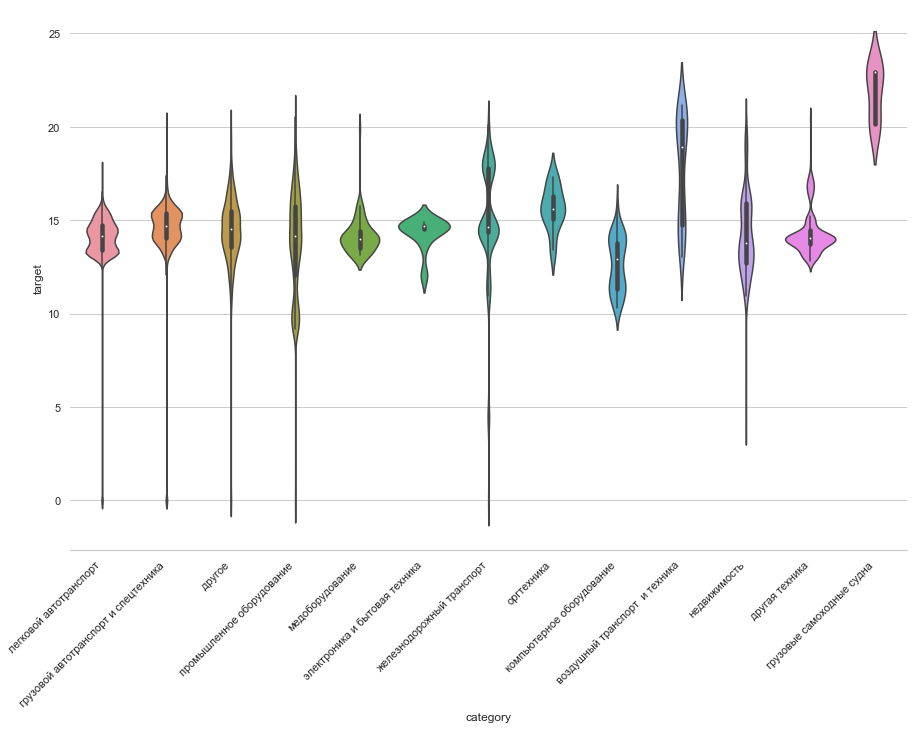

In [15]:
logdf = df[df['target'].notna()][['category','target']]
logdf['target'] = np.log1p(logdf['target'])
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(15, 10))

# Plot our violins.
sns.violinplot(x='category', y='target', data=logdf)

# Rotate the x-axis labels and remove the plot border on the left.
_ = plt.xticks(rotation=45, ha='right')
sns.despine(left=True)

Из графика видно, что у каждой категории разные свойства распределений, поэтому будем строить для каждой категории свою регрессионную модель.

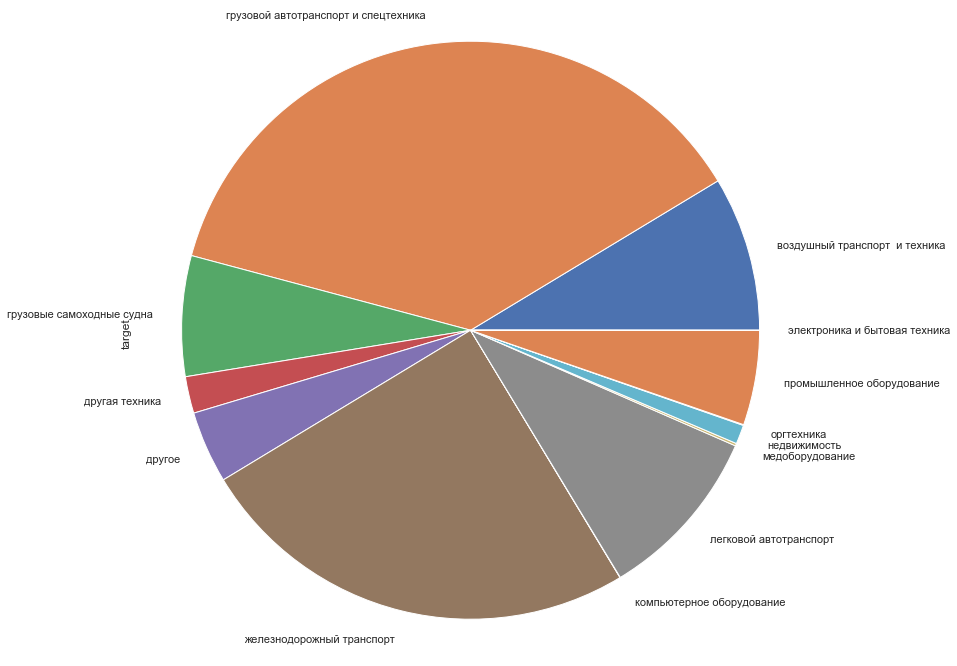

In [22]:
df.groupby('category')['target'].sum().plot(kind='pie')
plt.axis('equal')
plt.show()

На диаграмме изображено распределение суммарной стоимости услуг лизинга в каждой категории.

### Обучение отдельной регрессионной модели для каждой категории

In [50]:
df['prediction'] = 0
for cat in df['category'].unique():
    print('-'*124)
    print('Категория:',cat,'\nРазмер трейна и теста:',df[df['category']==cat].shape[0],'записей')
    train = df.loc[(df['category']==cat) & df.target.notna()][['a']]
    tr_index = train.index
    test = df.loc[(df['category']==cat) & df.target.isna()][['a']]
    te_index=test.index
    labels = df.loc[df.target.notna() & (df['category']==cat)][['target']]

    cv = CountVectorizer(ngram_range = (1,1)) 
    cv.fit(df.loc[(df['category']==cat),'a'])
    tr = cv.transform(train['a'])
    te = cv.transform(test['a'])

    prediction = np.zeros(te.shape[0])
    preds = np.zeros(tr.shape[0])
    i=1
    folds = 3
    kf = KFold(n_splits = folds, shuffle = True, random_state = 42)
    for train_index, val_index in kf.split(tr):
        print('\nFold:',i,'\n')
        X_train = tr.tocsr()[train_index]
        X_val = tr.tocsr()[val_index]
        y_train = labels.iloc[train_index]
        y_val = labels.iloc[val_index]
        model = CatBoostRegressor(iterations = 2000,learning_rate = 0.2, depth = 5,
                              loss_function = 'RMSE',eval_metric = 'RMSE',
                              early_stopping_rounds = 100, verbose = 1000)
        model.fit(X_train,y_train,use_best_model=True, eval_set=(X_val,y_val))
        prediction += model.predict(te.tocsr()) / folds
        preds[val_index] += model.predict(X_val)
        i+=1
        gc.collect()
    df.loc[df.index.isin(tr_index),'prediction'] = preds
    df.loc[df.index.isin(te_index),'prediction'] = prediction
df.loc[df['prediction'] < 0,'prediction'] = 0

----------------------------------------------------------------------------------------------------------------------------
Категория: компьютерное оборудование 
Размер трейна и теста: 986 записей

Fold: 1 

0:	learn: 1001778.9657823	test: 1229645.1988671	best: 1229645.1988671 (0)	total: 1.83ms	remaining: 3.66s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 600365.9376
bestIteration = 43

Shrink model to first 44 iterations.

Fold: 2 

0:	learn: 1008164.7640359	test: 1214371.4718672	best: 1214371.4718672 (0)	total: 2.77ms	remaining: 5.55s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 622312.3807
bestIteration = 46

Shrink model to first 47 iterations.

Fold: 3 

0:	learn: 1179447.5358489	test: 712534.4554048	best: 712534.4554048 (0)	total: 4.9ms	remaining: 9.79s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 561743.5629
bestIteration = 39

Shrink model to first 40 iterations.
-------------------------------------------------

Stopped by overfitting detector  (100 iterations wait)

bestTest = 75920458.68
bestIteration = 27

Shrink model to first 28 iterations.
----------------------------------------------------------------------------------------------------------------------------
Категория: оргтехника 
Размер трейна и теста: 1576 записей

Fold: 1 

0:	learn: 9582548.7881129	test: 9536131.1665170	best: 9536131.1665170 (0)	total: 597us	remaining: 1.19s
1000:	learn: 1038266.6770187	test: 7866106.3875340	best: 7866106.3875340 (1000)	total: 743ms	remaining: 742ms
1999:	learn: 1038266.6770187	test: 7866106.3875330	best: 7866106.3875330 (1998)	total: 1.53s	remaining: 0us

bestTest = 7866106.388
bestIteration = 1998

Shrink model to first 1999 iterations.

Fold: 2 

0:	learn: 9536438.1702623	test: 9385762.1524454	best: 9385762.1524454 (0)	total: 703us	remaining: 1.41s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 3691070.374
bestIteration = 82

Shrink model to first 83 iterations.

Fold: 3 



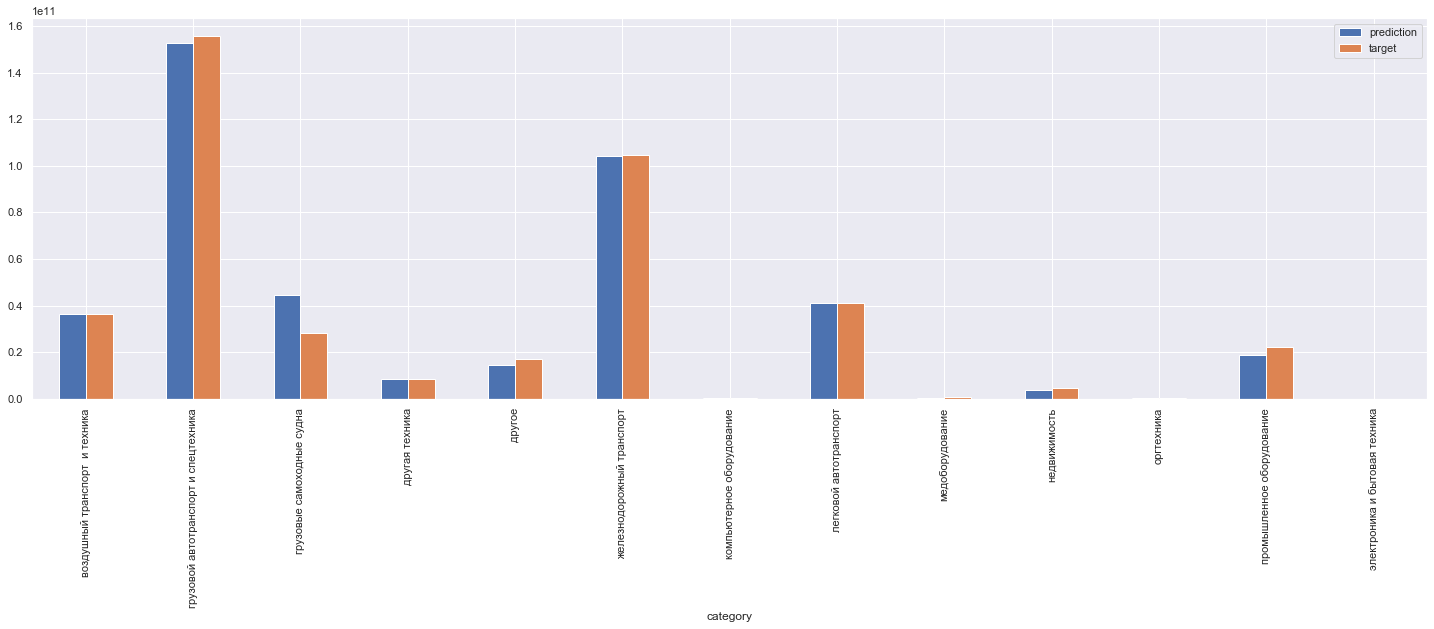

In [51]:
df[df.target.notna()].groupby('category')[['prediction','target']].sum().plot(kind = 'bar');

Предсказания близки к реальным значениям.

In [71]:
df.loc[df.target.notna(),'prediction'].sum(),df.loc[df.target.notna(),'target'].sum()

(424575702755.5607, 418579225435.9905)

In [73]:
df['prediction'].sum()

1776987049993.6233

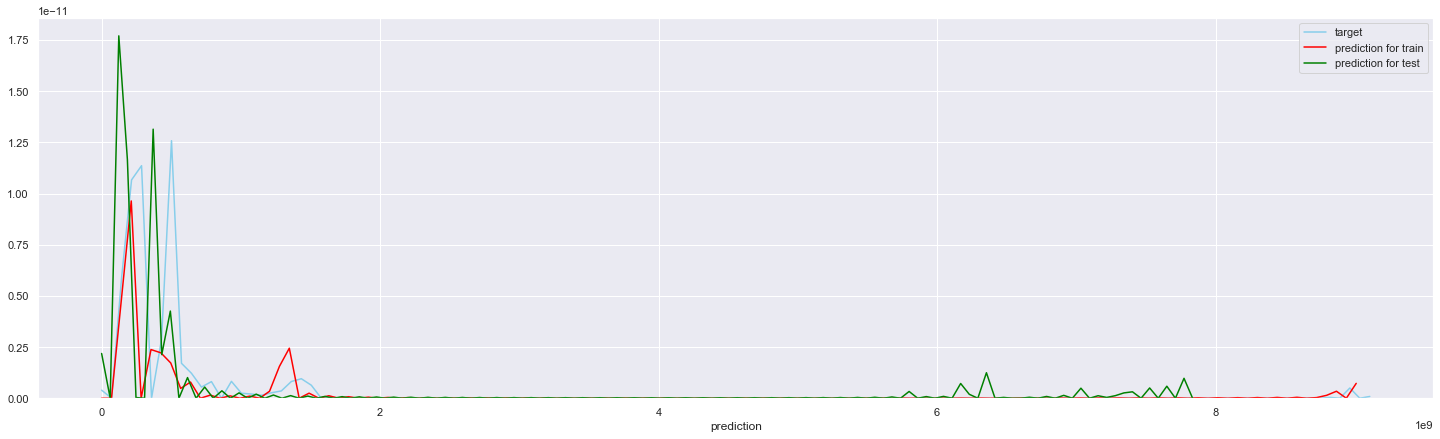

In [74]:
rcParams['figure.figsize'] = 25, 7
sns.distplot(df.loc[df.target.notna(),'target'] , bins=5,color="skyblue", label="target",rug=False, hist=False);
sns.distplot(df.loc[df.target.notna(),'prediction'] , color="red", label="prediction for train",rug=False, hist=False);
sns.distplot(df.loc[df.target.isna(),'prediction'] , color="green", label="prediction for test",rug=False, hist=False);

In [65]:
df[df['a'].str.contains('автомобиль')].sample(20)

,a,target,category,prediction
64568,рефрижератор 1757d2 fuso автомобиль canter,2.669492e+06,грузовой автотранспорт и спецтехника,2.743707e+06
156590,220d activity polo mercedes 4matic marco автомобиль заводский benz номер,NaN,легковой автотранспорт,3.609405e+06
118802,passat новый пассажирский volkswagen автомобиль,NaN,легковой автотранспорт,1.706309e+06
227030,kia optima автомобиль легковой,1.381364e+06,легковой автотранспорт,1.251736e+06
206997,partner 053 автомобиль peugeot,5.197881e+05,легковой автотранспорт,5.556991e+05
200337,lada автомобиль ks0y5l легковой largus,5.257627e+05,легковой автотранспорт,5.688086e+05
227855,focus ford автомобиль легковой,8.800000e+05,легковой автотранспорт,9.221993e+05
203501,газ автомобиль 3009d9 грузовой,5.364407e+05,грузовой автотранспорт и спецтехника,7.159862e+05
199793,gd 3010 автомобиль грузовой,1.757500e+06,грузовой автотранспорт и спецтехника,2.223009e+06
85975,234900 вис фургон грузовой грузовой автомобиль,NaN,грузовой автотранспорт и спецтехника,1.116353e+06


In [69]:
df.to_pickle('data2') # https://yadi.sk/d/BnpR6dcfW6UJXg